<a href="https://colab.research.google.com/github/AmirrezaJalili/Twitter-Tweets-Sentiment/blob/main/Twitter_Tweets_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Tweets Sentiment 👍😐👎

## Importing necessary tools

In [45]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from random import randint
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub

## Unzip data
data: https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset


In [46]:
# !unzip "drive/MyDrive/deep learning/zip files/Twitter Tweets Sentiment Dataset.zip" -d "drive/MyDrive/deep learning/data/Twitter Tweets Sentiment Dataset"

## Walk trough dataset

In [47]:
df = pd.read_csv("drive/MyDrive/deep learning/data/Twitter Tweets Sentiment Dataset/Tweets.csv")
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [48]:
df.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

there are missing values in our dataset, 

we'll drop them to make our model work properly

In [49]:
# drop missing values from the dataset
df = df.dropna()
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


row's number decresed only 1 

it looks like there was only one row with two missing values in that. 

In [50]:
#let's find out how many of each class there
df["sentiment"].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

number of each class is ~ 

40%

30%
 
30%

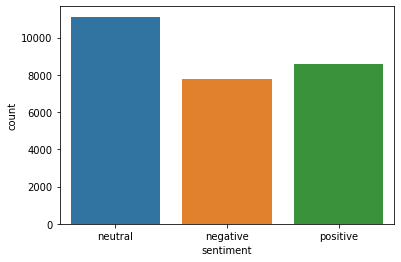

In [51]:
sns.countplot(x = df["sentiment"])
plt.show()

## show some sentences from dataset

In [52]:
for i in range(10):
  num = randint(0, len(df))
  sentence = df["text"][num]
  label = df["sentiment"][num]
  print(f"{label}:\n\t{sentence}")

negative:
	it was actually so hot today ..the sun has got his hat on . every one has got a tan except me
negative:
	_ What did he say about it?? Gosh! I missed the yesterday live chat.. I was at bed.. sick
neutral:
	 I really like miller park too  too bad the cubs aren`t leading, hopefully they can get it together soon
neutral:
	recorded some of a new song today! u wont hear it for a long time thooo... we might play it at shows tho! so comeeeeee
positive:
	Be beautiful        http://www.theskinsociety.com
neutral:
	Just got back.
negative:
	Still sick at home
positive:
	http://twitpic.com/4wh0l - im in love wit this fool from college hill
negative:
	binstruct suffers from an update of the mib package... and the developer of that package is on holidays
positive:
	 Hope that migraine doesn`t stick around for too long.


## split data to train and test
train = 80%

valid = 20%

In [53]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df["text"].to_numpy(),
                                                                            df["sentiment"].to_numpy(),
                                                                            random_state=42,
                                                                            test_size=0.2)
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(21984, 21984, 5496, 5496)

## Preprocessing

### binarizing labels:

In [54]:
lb = LabelBinarizer()
train_labels_binary = lb.fit_transform(train_labels)
val_labels_binary = lb.fit_transform(val_labels)
train_labels, val_labels

(array(['positive', 'positive', 'neutral', ..., 'neutral', 'positive',
        'positive'], dtype=object),
 array(['positive', 'negative', 'neutral', ..., 'neutral', 'negative',
        'neutral'], dtype=object))

In [55]:
MEAN_SEQ_LEN = sum([len(i.split()) for i in train_sentences])//len(train_sentences)
print(MEAN_SEQ_LEN)

12


In [56]:
# it's better to set output_sequence_length more than mean length of sentences.  
SEQ_LENGTH = 16

### vectorization(tokenization)

In [57]:
from re import split
text_vectorizer = TextVectorization(max_tokens=10000,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    output_mode="int",
                                    output_sequence_length=SEQ_LENGTH)

## creating model

In [58]:
embedding = layers.Embedding(input_dim=10000,
                                      output_dim=64,
                                      input_length=SEQ_LENGTH,
                                      name="embedding_1")
embedding

In [59]:
text_vectorizer.adapt(train_sentences)
random_sentence = random.choice(train_sentences)
print(f"original sentence:\n\t{random_sentence}\nvectorized sentence:\n\t{text_vectorizer([random_sentence])}\nembedded sentence:\n\t{embedding(text_vectorizer([random_sentence]))}")

original sentence:
	What a bad day!
vectorized sentence:
	[[ 59   5 113  23   0   0   0   0   0   0   0   0   0   0   0   0]]
embedded sentence:
	[[[ 0.00375708 -0.03489511  0.04057686 ...  0.02654744  0.03077454
   -0.0391353 ]
  [ 0.04416797  0.03470066  0.02871371 ...  0.04179043  0.03170761
    0.01513112]
  [-0.04084424 -0.01031585  0.00871443 ... -0.00813218 -0.00838417
   -0.04606178]
  ...
  [ 0.0216409  -0.03101757 -0.04572031 ...  0.02642454 -0.004095
    0.02969743]
  [ 0.0216409  -0.03101757 -0.04572031 ...  0.02642454 -0.004095
    0.02969743]
  [ 0.0216409  -0.03101757 -0.04572031 ...  0.02642454 -0.004095
    0.02969743]]]


In [60]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_LSTM = tf.keras.Model(inputs, outputs, name="LSTM_model")

In [61]:
model_LSTM.compile(loss="categorical_crossentropy",
              metrics="categorical_accuracy",
              optimizer="Adam")
model_LSTM.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 16)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 16, 64)            640000    
                                                                 
 lstm_2 (LSTM)               (None, 16, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                        

In [62]:
model_LSTM.fit(train_sentences,
          train_labels_binary,
          validation_data=(val_sentences, val_labels_binary),
          epochs=5,
          batch_size=32)

Epoch 1/5
687/687 [==============================] - 18s 17ms/step - loss: 0.8383 - categorical_accuracy: 0.6129 - val_loss: 0.7515 - val_categorical_accuracy: 0.6747
Epoch 2/5
687/687 [==============================] - 11s 16ms/step - loss: 0.6220 - categorical_accuracy: 0.7439 - val_loss: 0.7382 - val_categorical_accuracy: 0.6860
Epoch 3/5
687/687 [==============================] - 11s 16ms/step - loss: 0.5232 - categorical_accuracy: 0.7965 - val_loss: 0.7738 - val_categorical_accuracy: 0.6738
Epoch 4/5
687/687 [==============================] - 11s 16ms/step - loss: 0.4434 - categorical_accuracy: 0.8310 - val_loss: 0.8873 - val_categorical_accuracy: 0.6690
Epoch 5/5
687/687 [==============================] - 11s 16ms/step - loss: 0.3706 - categorical_accuracy: 0.8564 - val_loss: 0.9549 - val_categorical_accuracy: 0.6563


hmmmmm...
its little bit better than guessing😁😂

but where did i make mistake...?🤔

## Nave Base:
let's try Multinomial Nave Base of sklearn...

In [63]:
labelencoder = LabelEncoder()
train_labels_ml = labelencoder.fit_transform(train_labels)
val_labels_ml = labelencoder.fit_transform(val_labels)
train_labels_ml, val_labels_ml

(array([2, 2, 1, ..., 1, 2, 2]), array([2, 0, 1, ..., 1, 0, 1]))

### Creating model

In [64]:
model_NB = Pipeline([
                     ("tfidf", TfidfVectorizer()),
                     ("NB", MultinomialNB())
])

In [65]:
model_NB.fit(train_sentences, train_labels_ml)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('NB', MultinomialNB())])

In [66]:
model_NB.score(val_sentences, val_labels_ml)

0.606259097525473

ohhh no...!😫

I should try other models in next commits

but really whats wrong with my dataset?🤔

if you have better idea i'll be thankful if you share with me😃


## Let's try a pre-trained model
model:"https://tfhub.dev/google/universal-sentence-encoder-large/5"

In [67]:
tf_hub_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                                  input_shape=[],
                                  dtype=tf.string)

In [68]:
tf_hub_model = tf.keras.Sequential([tf_hub_embedding,
                                    layers.Dense(64, activation="relu"),
                                    layers.Dense(3, activation="softmax")
])


In [69]:
tf_hub_model.compile(loss = "categorical_crossentropy",
                       optimizer = "Adam",
                       metrics = ["categorical_accuracy"])
tf_hub_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dense_14 (Dense)            (None, 64)                32832     
                                                                 
 dense_15 (Dense)            (None, 3)                 195       
                                                                 
Total params: 147,387,907
Trainable params: 33,027
Non-trainable params: 147,354,880
_________________________________________________________________


In [70]:
tf_hub_model.fit(train_sentences, train_labels_binary,
                 epochs=5,
                 validation_data=(val_sentences, val_labels_binary))

Epoch 1/5
687/687 [==============================] - 96s 95ms/step - loss: 0.7222 - categorical_accuracy: 0.6902 - val_loss: 0.6519 - val_categorical_accuracy: 0.7172
Epoch 2/5
687/687 [==============================] - 62s 90ms/step - loss: 0.6270 - categorical_accuracy: 0.7304 - val_loss: 0.6416 - val_categorical_accuracy: 0.7213
Epoch 3/5
687/687 [==============================] - 59s 86ms/step - loss: 0.6097 - categorical_accuracy: 0.7372 - val_loss: 0.6415 - val_categorical_accuracy: 0.7223
Epoch 4/5
687/687 [==============================] - 60s 88ms/step - loss: 0.5981 - categorical_accuracy: 0.7443 - val_loss: 0.6419 - val_categorical_accuracy: 0.7245
Epoch 5/5
687/687 [==============================] - 58s 84ms/step - loss: 0.5889 - categorical_accuracy: 0.7494 - val_loss: 0.6463 - val_categorical_accuracy: 0.7216
